# Rank Candidates

Take candidates from EnhDesign notebook, marginalize over different background with held-out model folds and rank them.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm
from matplotlib.patches import Rectangle
import pyBigWig

import sys
sys.path.append("/users/surag/kundajelab/retina-models/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq, get_cts
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats
import joblib

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [7]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [8]:
models = defaultdict(dict)
ctypes = []
FOLDS = 5

with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for x in glob.glob("/oak/stanford/groups/akundaje/surag/projects/retina_Howard/models/20220202_bpnet/fold0/saved/*.h5"):
        ctype = x.split("/")[-1].split(".")[0]
        ctypes.append(ctype)
        print(ctype)
        
        for i in range(FOLDS):
            models[ctype][i] = tf.keras.models.load_model(x.replace("fold0", "fold" + str(i)))

Astrocyte


2025-02-10 17:25:28.261972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 17:25:29.739742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10544 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:af:00.0, compute capability: 7.0


Microglia
AIIamacrine
GABAamacrine
Glyamacrine
Rodbipolar
ONconebipolar
OFFconebipolar
Horizontal
Mullerglia
Rod
Cone
Retinalganglioncell


In [9]:
len(ctypes)

13

In [10]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in range(FOLDS):
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [11]:
INP_LEN = models[ctypes[0]][0].input_shape[1]
OUT_LEN = models[ctypes[0]][0].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

### Load predictions over peak

To map to quantile per model.

In [12]:
peak_preds = joblib.load("../20220503_design/out/peak_preds.joblib")

In [13]:
peak_preds.keys()

dict_keys(['Rod', 'OFFconebipolar', 'Retinalganglioncell', 'Horizontal', 'AIIamacrine', 'Microglia', 'Glyamacrine', 'Mullerglia', 'GABAamacrine', 'ONconebipolar', 'Astrocyte', 'Cone', 'Rodbipolar'])

## Marginalize

### Prepare background sequences to marginalize over

In [14]:
TARGET = "OFFconebipolar"

In [15]:
bg_set = pd.read_csv("/mnt/lab_data3/surag/kundajelab/retina-design/data/filtered_negatives/{}_peakCalls_sorted.gc.neg.bed.filt.neg.bed".format(TARGET),
                         sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(100)

bg_set.head()

,chr,start,end,1,2,3,4,5,6,summit
4819,chr1,64716000,64719000,.,.,.,.,.,.,1500
49143,chr9,37362000,37365000,.,.,.,.,.,.,1500
20302,chr3,139617000,139620000,.,.,.,.,.,.,1500
24140,chr4,147711000,147714000,.,.,.,.,.,.,1500
69597,chr15,93342000,93345000,.,.,.,.,.,.,1500


In [16]:
IDX=0
bg_seqs = one_hot.dna_to_one_hot([str(hg38[bg_set.iloc[i]['chr']][bg_set.iloc[i]['start'] + bg_set.iloc[i]['summit'] - INP_LEN//2:bg_set.iloc[i]['start'] + bg_set.iloc[i]['summit'] + INP_LEN//2]) \
                                   for i in range(len(bg_set))])

In [17]:
bg_seqs.shape

(100, 2114, 4)

### Predict

Load candidates.

In [18]:
candidates = joblib.load("./out/v1/{}_candidates.joblib".format(TARGET))
candidates.shape

(100, 250, 4)

In [19]:
PRED_FOLDS = [3,4]

In [20]:
preds = defaultdict(lambda : defaultdict(dict))

In [ ]:
for idx, cand in enumerate(tqdm(candidates)):
    seqs_w_cand = bg_seqs.copy()
    seqs_w_cand[:, INP_LEN//2 - candidates.shape[1]//2:INP_LEN//2 + candidates.shape[1]//2] = cand
    
    for m in models:
        for fold in PRED_FOLDS:
            preds[idx][m][fold] = models[m][fold].predict(seqs_w_cand)

  0%|                                                                                                                                 | 0/100 [00:00<?, ?it/s]/users/surag/anaconda3/envs/chrombpnet/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-02-10 17:34:18.188060: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
 18%|█████████████████████▌                                                                                                  | 18/100 [03:44<11:43,  8.58s/it]

In [ ]:
preds_quants = defaultdict(lambda : defaultdict(dict))
for idx in range(len(candidates)):
    for m in models:
        for fold in PRED_FOLDS:
            preds_quants[idx][m][fold] = np.mean([np.mean(peak_preds[m] < x) for x in preds[idx][m][fold][1]])

In [23]:
np.mean(list(preds_quants[0]['Rod'].values()))

0.2309515

In [24]:
preds_quants_fold_avg = defaultdict(lambda : dict())
for idx in range(len(candidates)):
    for m in models:
        preds_quants_fold_avg[idx][m] = np.mean(list(preds_quants[idx][m].values()))

In [25]:
gaps = [(i, preds_quants_fold_avg[i][TARGET] - max([v for k,v in preds_quants_fold_avg[i].items() if k!=TARGET])) \
            for i in range(len(candidates))]

In [26]:
sorted(gaps, key=lambda x:-x[1])

[(66, 0.4562395000000002),
 (81, 0.39938299999999993),
 (0, 0.353665),
 (33, 0.34146699999999996),
 (43, 0.322059),
 (20, 0.3204079999999999),
 (5, 0.31629050000000003),
 (69, 0.3142395),
 (42, 0.31041100000000005),
 (19, 0.301922),
 (82, 0.30159499999999995),
 (88, 0.27502800000000005),
 (39, 0.27276999999999996),
 (68, 0.27092200000000016),
 (50, 0.2661605),
 (11, 0.25161199999999995),
 (74, 0.250887),
 (45, 0.24602049999999998),
 (8, 0.24112100000000003),
 (23, 0.22893299999999994),
 (32, 0.22504400000000002),
 (62, 0.22039799999999987),
 (61, 0.20733100000000004),
 (59, 0.19201450000000003),
 (10, 0.18155050000000006),
 (34, 0.17271999999999998),
 (84, 0.17129300000000003),
 (97, 0.16663700000000004),
 (86, 0.16373100000000007),
 (83, 0.1589759999999999),
 (60, 0.14762700000000006),
 (78, 0.1457595),
 (49, 0.13742449999999995),
 (1, 0.13260350000000004),
 (35, 0.13159449999999995),
 (37, 0.12609499999999996),
 (54, 0.12221800000000005),
 (94, 0.11951700000000004),
 (18, 0.11783149999999998),
 (26, 0.11358349999999995),
 (71, 0.10757499999999998),
 (46, 0.10486299999999993),
 (27, 0.10178999999999994),
 (87, 0.07909450000000001),
 (25, 0.06974250000000004),
 (80, 0.0695),
 (65, 0.0668455),
 (72, 0.06223799999999996),
 (4, 0.06141149999999995),
 (31, 0.053443000000000074),
 (95, 0.05340649999999997),
 (58, 0.0511365),
 (91, 0.04906000000000005),
 (98, 0.04185250000000007),
 (16, 0.041263500000000064),
 (73, 0.03781300000000004),
 (2, 0.02522049999999998),
 (15, 0.024900499999999992),
 (89, 0.02342149999999993),
 (93, 0.02231700000000003),
 (67, 0.02202350000000003),
 (29, 0.020635999999999988),
 (56, 0.01945450000000004),
 (30, -0.0005455000000000876),
 (21, -0.005016500000000035),
 (7, -0.005878500000000009),
 (14, -0.006828499999999987),
 (3, -0.011580499999999994),
 (76, -0.02180000000000004),
 (28, -0.030512999999999957),
 (64, -0.03126100000000004),
 (96, -0.04434199999999999),
 (92, -0.045792500000000014),
 (13, -0.0465509999999999),
 (77, -0.04705200000000001),
 (47, -0.049818999999999995),
 (17, -0.05014850000000004),
 (12, -0.050483500000000014),
 (57, -0.0525855),
 (22, -0.05377150000000003),
 (9, -0.05524899999999999),
 (99, -0.055605000000000016),
 (53, -0.060148999999999994),
 (48, -0.06318950000000001),
 (55, -0.06657949999999999),
 (70, -0.06694449999999996),
 (79, -0.06843649999999996),
 (36, -0.07034499999999988),
 (40, -0.07348999999999994),
 (24, -0.07638050000000002),
 (90, -0.07941600000000015),
 (38, -0.10060150000000001),
 (75, -0.10641000000000006),
 (51, -0.12691999999999992),
 (44, -0.14213849999999995),
 (41, -0.15032499999999993),
 (52, -0.1566344999999999),
 (6, -0.16751599999999994),
 (85, -0.17758499999999997),
 (63, -0.20099999999999996)]

In [41]:
preds_quants_fold_avg[66]

{'Astrocyte': 0.07804749999999999,
 'Microglia': 0.22185849999999996,
 'AIIamacrine': 0.10942099999999999,
 'GABAamacrine': 0.152627,
 'Glyamacrine': 0.07351550000000001,
 'Rodbipolar': 0.18085749999999995,
 'ONconebipolar': 0.155663,
 'OFFconebipolar': 0.7111150000000002,
 'Horizontal': 0.08216,
 'Mullerglia': 0.118031,
 'Rod': 0.2548755,
 'Cone': 0.12633650000000002,
 'Retinalganglioncell': 0.1070295}

In [42]:
one_hot.one_hot_to_dna(candidates)[66]

'TGAGCAAATTTTCTCCTTATCTTTGGTTTATAGCAGTTTGACTATGCTATGCTTGTATGGGATTTTCTTCACATTTATTCTGCTTCGAGTTGTCTGTTTAATCCCTTCAATCTGGACCCACTCAGATTTAAGTTTTAATTTCTTTCCTTTTTTTTTCTTCTTGAACAGAATCTAAATCCCCATAATCCGCTGGAGTGCAGCAGTATGATGTTGGCTCACTGCATTTTCTAAAAAATATGAAGAAACGATT'

In [43]:
one_hot.one_hot_to_dna(candidates)[81]

'GTGGTGAGCTATTGGAATAATCACAGTCATTTTCTTCATGTTTTTTTCAAGGAATAGACCCATAATCCCTTTAATCCCTGATTTGGCATCCAAGATGGCTGAATAGGAAATGCACATCTGGAAATGCTGGAGATAAGAGAGAGAAAGAGAATCTGTGTGTGTGTGTGTGTGTGTGTAATATATGTTATACATTTTACATATATATTACCTATATGAAAAATTTATCCTTGACTATTAACTAATACCATGT'

In [44]:
one_hot.one_hot_to_dna(candidates)[0]

'ACCTTCTAAGAAAAGATGCATGGTACATAAATGACCTTGCTTCTTTGATATGTCATTATTTTTATTATATCCTTATACTTGTCTGATTGGTATTGGTAGTCTGGATAAAGAATCTAGATCATACATCATTTTCCCAAGAAAATGATGACTTTTTTTTCTTTGGGATTAAAGGGACTAATCCCTAAGCTGTTCAATCTTGGCAGTTCTCATGACATCAGATGATTTTTCTTGGCTTATTGCAACCTCCACC'

Save scores to file

In [45]:
preds_quants_df = OrderedDict({'seq':one_hot.one_hot_to_dna(candidates)})

selected = [False]*len(candidates)

selected[66] = True
selected[81] = True
selected[0] = True

preds_quants_df['selected'] = selected

for fold in PRED_FOLDS:
    for m in models:
        preds_quants_df[f"{m}_fold_{fold}"] = [preds_quants[i][m][fold] for i in range(len(preds_quants))]

preds_quants_df = pd.DataFrame(preds_quants_df)

In [47]:
preds_quants_df.to_csv(f"./out/{TARGET}_candidates_scores_fold_3_4.tsv", sep='\t', index=False)

## Viz Importance

In [49]:
imp_quantiles_low = {}
imp_quantiles_high = {}

for m in models:
    with open(f"/oak/stanford/groups/akundaje/surag/projects/retina_Howard/models/20220202_bpnet/fold0/interpret_bigwigs/{m}.counts.importance.stats.txt", "r") as f:
        d = [x.strip() for x in f]
        
    imp_quantiles_low[m] = float(d[1].split('\t')[1])
    imp_quantiles_high[m] = float(d[7].split('\t')[1])

In [50]:
imp_quantiles_high

{'Astrocyte': 0.070498,
 'Microglia': 0.082066,
 'AIIamacrine': 0.080046,
 'GABAamacrine': 0.091997,
 'Glyamacrine': 0.084268,
 'Rodbipolar': 0.104894,
 'ONconebipolar': 0.102988,
 'OFFconebipolar': 0.104597,
 'Horizontal': 0.063544,
 'Mullerglia': 0.103798,
 'Rod': 0.133673,
 'Cone': 0.104068,
 'Retinalganglioncell': 0.071821}

In [59]:
IDX = 0

In [60]:
cur_raw_seqs = np.expand_dims(bg_seqs[0].copy(), 0)
cur_raw_seqs[:, INP_LEN//2 - candidates[IDX].shape[0]//2:INP_LEN//2 + candidates[IDX].shape[0]//2] = candidates[IDX]

# counts_shap_scores = np.array([model_count_explainers[CTYPE1][i].shap_values(cur_raw_seqs) for i in range(FOLDS)]).mean(0)
# projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)

# FOLD=4

proj_scores = {}
for m in models:
    counts_shap = np.vstack([model_count_explainers[m][fold].shap_values(cur_raw_seqs) for fold in PRED_FOLDS]).mean(0, keepdims=True)
    proj_scores[m] = np.multiply(cur_raw_seqs, counts_shap)

In [61]:
proj_scores[m].shape

(1, 2114, 4)

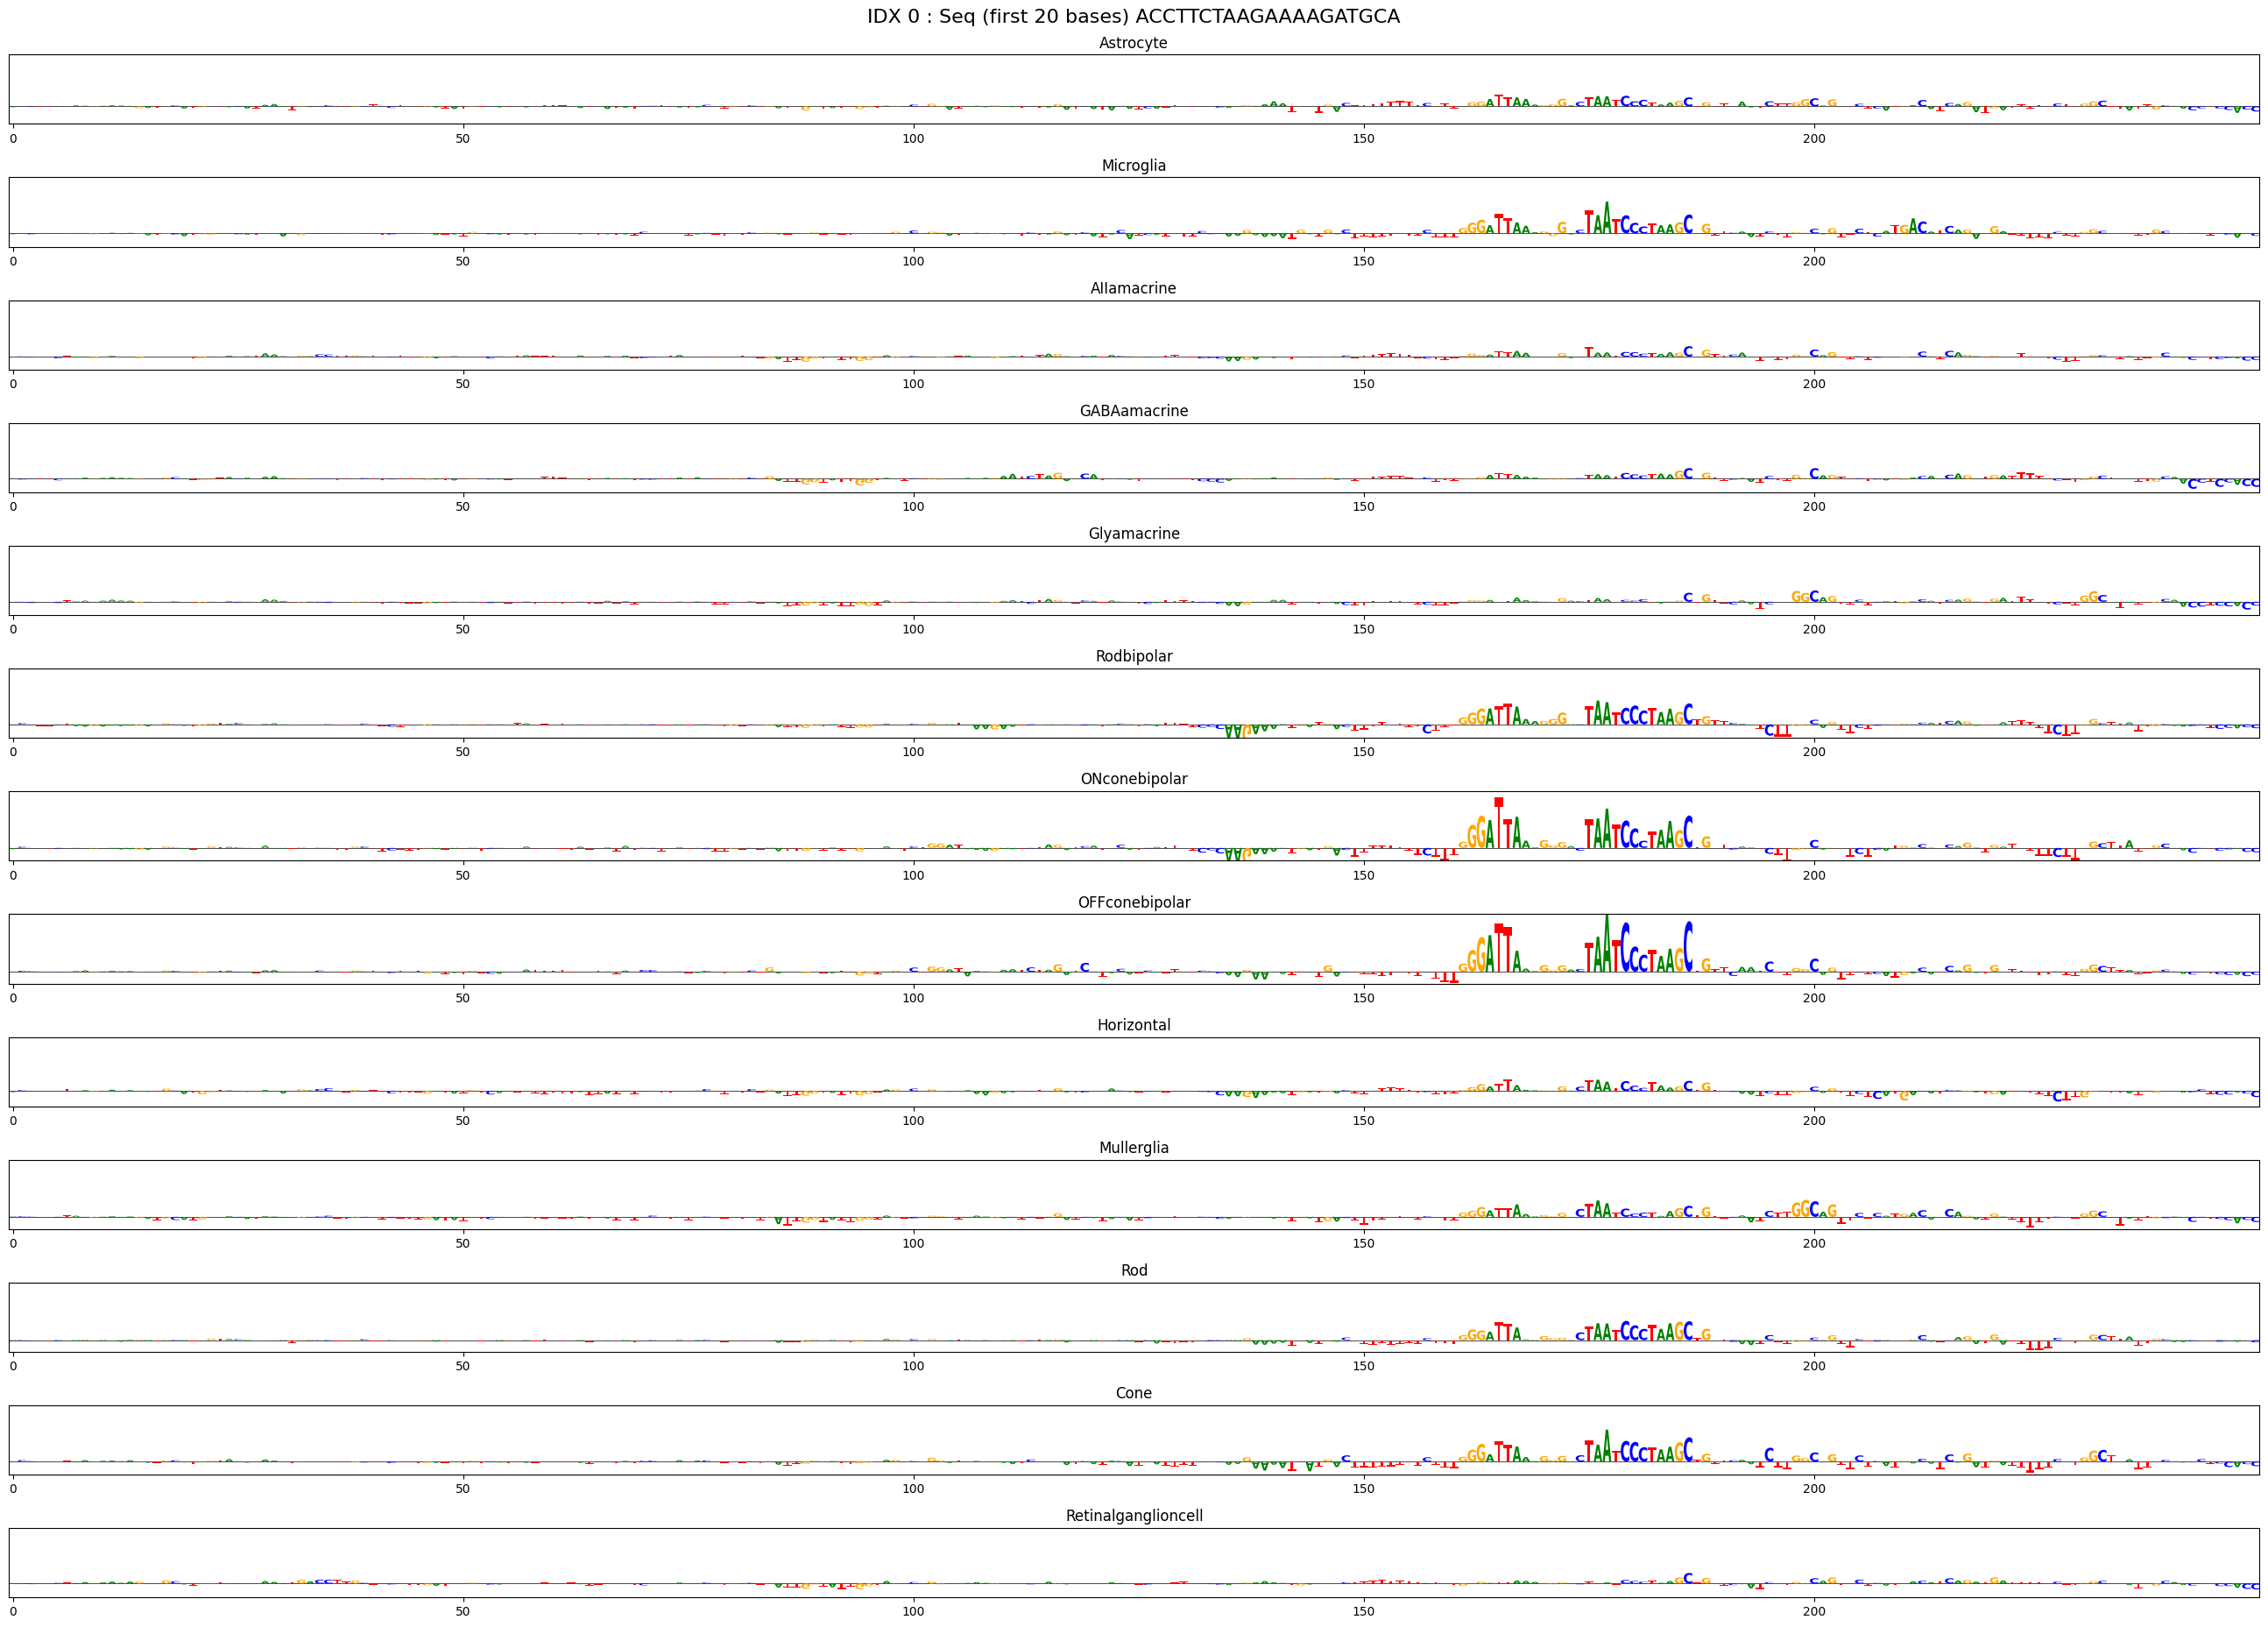

In [62]:
WINDOW = 250
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(len(models), figsize=(WINDOW/10 + 1,1.5*len(models)))

for i,m in enumerate(models):
    cur_scores = proj_scores[m][0][SLICE_START:SLICE_END]
    cur_scores[cur_scores > imp_quantiles_high[m]+.01] = imp_quantiles_high[m]+.01
    logomaker.Logo(pd.DataFrame(cur_scores, columns=['A','C','G','T']),
                  ax=ax[i])
    ax[i].title.set_text(m)
    ax[i].set_ylim((imp_quantiles_low[m]-.01, imp_quantiles_high[m]+.01))
    ax[i].tick_params(axis='y', left=False, labelleft=False)

short_seq = one_hot.one_hot_to_dna(candidates[IDX:IDX+1])[0][:20]

fig.suptitle(f"IDX {IDX} : Seq (first 20 bases) {short_seq}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

plt.savefig(f"./figs/{TARGET}_IDX_{IDX}_({short_seq}).pdf")
plt.show()